# Summer School

## Using Neural Networks and Variational Monte Carlo for Ground State Search

Let us consider the physics of the problem.

- We are looking at a 2D lattice of Rydberg atoms
- We will be using the Ising Model
- We are assuming all-to-all interaction between all lattice sites
- The Hamiltonian is as follows

$$
\begin{equation}
\tilde{H} = - \frac{\Omega}{2} \sum_{i = 1}^N \left( \hat{\sigma}_i^x \right) - \delta \sum_{i = 1}^N \left ( \hat{n}_i \right )
\end{equation} + \sum_{i,j} \left ( V_{ij} \hat{n}_i \hat{n}_j \right )
$$


where $V_{ij} = \frac{7}{| \textbf{r}_i - \textbf{r}_j |^6}$.

## Library Imports

In [1]:
import jax
import math
import optax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from functools import partial
from flax.training import train_state



from flax.core import freeze, unfreeze

In [2]:
class TQSPositionalEncoding2D(nn.Module):
    d_model: int
    param_dim: int
    max_system_size: tuple = (50, 50)
    dropout_rate: float = 0.0

    def setup(self):
        # validate max_system_size
        max_system_size = np.array(self.max_system_size).reshape(-1)
        assert len(max_system_size) == 2
        
		# positional encoding
        x, y = max_system_size
        channels = int(np.ceil(self.d_model / 4) * 2)
        div_term = jnp.exp(jnp.arange(0, channels, 2) * (-math.log(10000.0) / channels))

        pos_x = jnp.arange(x).reshape(-1, 1)
        pos_y = jnp.arange(y).reshape(-1, 1)
        sin_inp_x = pos_x * div_term
        sin_inp_y = pos_y * div_term

        emb_x = jnp.zeros((x, channels))
        emb_y = jnp.zeros((y, channels))

        emb_x = emb_x.at[:, 0::2].set(jnp.sin(sin_inp_x))
        emb_x = emb_x.at[:, 1::2].set(jnp.cos(sin_inp_x))
        emb_y = emb_y.at[:, 0::2].set(jnp.sin(sin_inp_y))
        emb_y = emb_y.at[:, 1::2].set(jnp.cos(sin_inp_y))

        pe = jnp.zeros((x, y, 2 * channels))
        pe = pe.at[:, :, :channels].set(emb_x[:, None, :])
        pe = pe.at[:, :, channels:].set(emb_y[None, :, :])
        pe = pe[:, :, :self.d_model].reshape(x, y, 1, self.d_model)
        

		# set instance variables
        self.pe = pe
        self.mx_system_size = max_system_size
        self.dropout_layer = nn.Dropout(rate=self.dropout_rate)
        self.param_embedding = self.param('param_embedding', nn.initializers.normal(stddev=0.02), (self.param_dim, 1, self.d_model))

    def __call__(self, x, system_size=None):
        if system_size is None:
            system_size = self.mx_system_size
        pe = self.pe[:system_size[0], :system_size[1]].reshape(-1, 1, self.d_model)
        pe = jnp.concatenate([self.param_embedding, pe], axis=0)
        x = x + pe[:x.shape[0]]
        return self.dropout_layer(x, deterministic=False)

## Transformer Model

In [3]:
class TransformerEncoderLayer(nn.Module):
    emb_size: int
    nhead: int
    dim_feedforward: int
    dropout: float = 0.1

    def setup(self):
        self.self_attn = nn.SelfAttention(num_heads=self.nhead, qkv_features=self.emb_size, dropout_rate=self.dropout)
        self.linear1 = nn.Dense(self.dim_feedforward)
        self.linear2 = nn.Dense(self.emb_size)
        self.dropout_layer = nn.Dropout(self.dropout)
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()

    def __call__(self, src, deterministic=True):
        src2 = self.self_attn(src, deterministic=deterministic)
        src = src + self.dropout_layer(src2, deterministic=deterministic)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout_layer(nn.relu(self.linear1(src)), deterministic=deterministic))
        src = src + self.dropout_layer(src2, deterministic=deterministic)
        src = self.norm2(src)
        return src


## Transformer Quantum State

In [4]:
class TransformerQuantumState(nn.Module):
    emb_size: int = 32
    nhead: int = 8
    num_encoder_layers: int = 8
    dim_feedforward: int = 128
    dropout: float = 0.0

    def setup(self):
        self.embedding = nn.Embed(num_embeddings=1000, features=self.emb_size)  # Adjust input dimension as needed
        self.transformer_encoder = [
            TransformerEncoderLayer(self.emb_size, self.nhead, self.dim_feedforward, self.dropout) 
            for _ in range(self.num_encoder_layers)
        ]
        self.amplitude_head = nn.Dense(1)
        self.phase_head = nn.Dense(1)
    
    def __call__(self, src, train=True):
        deterministic = not train
        src = self.embedding(src) * jnp.sqrt(self.emb_size)
        for layer in self.transformer_encoder:
            src = layer(src, deterministic=deterministic)
        amplitude = self.amplitude_head(src).squeeze(-1)
        phase = jnp.pi * jnp.tanh(self.phase_head(src).squeeze(-1))
        return amplitude, phase


## Training the Model

In [5]:
model = TransformerQuantumState()

@jax.jit
def compute_loss(params, batch):
    amplitude, phase = model.apply({'params': params}, batch)
    # Define your loss function based on your task
    loss = jnp.mean((amplitude - batch['amplitude'])**2 + (phase - batch['phase'])**2)
    return loss

@jax.jit
def train_step(params, opt_state, batch):
    loss, grads = jax.value_and_grad(compute_loss)(params, batch)
    opt_state = opt_state.apply_gradients(grads=grads)
    return opt_state.params, opt_state, loss

def train(params, state, data_loader, num_epochs=100):
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in data_loader:
            params, state, loss = train_step(params, state, batch)
            total_loss += loss
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(data_loader)}')




In [6]:

# Initialize model and optimizer
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 10), dtype=jnp.int32))['params']  # Example input
optimizer = optax.adam(learning_rate=0.001)
opt_state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)

# Define a data loader with your data
data_loader = [{'amplitude': jnp.array([0.1]), 'phase': jnp.array([0.2])}] * 100

In [7]:
# data_loader

In [8]:
# Train the model
# train(params, opt_state, data_loader)

## Sampling

In [9]:
def sample(model, params, num_samples, sequence_length, key):
    samples = []
    for _ in range(num_samples):
        sample_seq = []
        for i in range(sequence_length):
            src = jnp.array(sample_seq).reshape(1, -1)
            amplitude, _ = model.apply({'params': params}, src)
            probabilities = nn.activation.log_softmax(amplitude)
            next_token = jax.random.choice(key, jnp.arange(probabilities.shape[-1]), p=probabilities)
            sample_seq.append(next_token)
        samples.append(sample_seq)
    return samples

# Example usage:
# key = jax.random.PRNGKey(0)
# samples = sample(model, params, num_samples=1000, sequence_length=10, key=key)


In [10]:
# Usage example for positional encoding
if __name__ == "__main__":
    import jax.random as random
    
    key = random.PRNGKey(0)
    model = TQSPositionalEncoding2D(d_model=512, param_dim=10)
    x = random.normal(key, (60, 32, 512))  # Example input: [sequence length, batch size, embed dim]

    # Initialize parameters
    params = model.init(key, x)

    # Apply model
    output = model.apply(params, x)
    print(output.shape)


(60, 32, 512)


In [11]:
# output

In [12]:
import jax.numpy as jnp

def get_square_mask(sz):
    mask = jnp.triu(jnp.ones((sz, sz)), k=0).T
    mask = jnp.where(mask == 0, -jnp.inf, mask)
    mask = jnp.where(mask == 1, 0.0, mask)
    return mask

# Example usage:
sz = 4
mask = get_square_mask(sz)
print(mask)

[[  0. -inf -inf -inf]
 [  0.   0. -inf -inf]
 [  0.   0.   0. -inf]
 [  0.   0.   0.   0.]]


In [13]:
def binomial_sampling(key, probs, total_counts):
    return jax.random.binomial(key, n=total_counts, p=probs)

In [14]:
def sample_from_transformer(key, params, model, batch_size = 1000, max_unique = 100):
    # setting up
    assert model.phys_dim == 2, "Only spin 1/2 systems are supported"
    init_batch_size = batch_size
    seq_len = np.prod(model.system_size)
    samples = jnp.array((0, 1)) # initalize empty samples
    sample_count = jnp.array([batch_size], dtype=jnp.int32)
    keys = jax.random.split(key, seq_len)
	
    def step(i, state):
        samples, sample_count = state    
        log_probs = model.apply({'params': params}, samples)
        probs = jnp.exp(log_probs[-1])
        
		# sample from probs
        key = keys[i]
        
        if len(sample_count) < max_unique:
            distribution = binomial_sampling(key, probs[:, 0], sample_count)
            zero_count = distribution  # (batch, )
            one_count = sample_count - zero_count
            sample_count = jnp.concatenate([zero_count, one_count], axis=0)
            mask = sample_count > 0

            batch = samples.shape[1]
            samples = jnp.concatenate([jnp.concatenate([samples, jnp.zeros((1, batch))], axis=0),
                                       jnp.concatenate([samples, jnp.ones((1, batch))], axis=0)], axis=1)
            samples = samples[:, mask]  # (seq, batch), with updated batch
            sample_count = sample_count[mask]  # (batch, )
        else:
            sampled_spins = jax.random.categorical(key, probs, axis=1)  # (batch,)
            samples = jnp.concatenate([samples, sampled_spins[jnp.newaxis, :]], axis=0)
            
        return samples, sample_count
    
    samples, sample_count = jax.lax.fori_loop(0, seq_len, step, (samples, sample_count))
    
	# retrun samples and relative frequencies
    return sample, sample_count / init_batch_size

In [15]:
# def init_seq(self):
#         system_size = self.system_size
#         param = self.param
#         parity = (system_size % 2).to(torch.get_default_dtype())  # (n_dim, )
#         size_input = torch.diag(system_size.log())  # (n_dim, n_dim)

#         init = torch.zeros(self.seq_prefix_len, 1, self.input_dim)

#         # sequence consists of: [log(system_size[0]) log(system_size[1]) params spins]
#         # input consists of: [phys_dim_0 phys_dim_1 log(system_size[0]) log(system_size[1]) parity(system_size) mask_token params]

#         init[:self.n_dim, :, self.phys_dim:self.phys_dim + self.n_dim] = size_input.unsqueeze(1)  # (n_dim, 1, n_dim)
#         init[:self.n_dim, :, self.phys_dim + self.n_dim] = parity.unsqueeze(1)  # (n_dim, 1)

#         param_offset = self.phys_dim + self.n_dim + 2
#         for i in range(self.param_dim):
#             init[self.n_dim + i, :, param_offset + i] += param[i]
#         return init 


# def wrap_spins(self, spins):
#         """
#             prefix: (prefix_len, 1, input_dim)
#             spins: (n, batch)
#         """
#         phys_dim = 2
#         prefix = self.init_seq()
#         prefix_len, _, input_dim = prefix.shape
#         n, batch = spins.shape
#         src = torch.zeros(prefix_len + n, batch, input_dim)
#         src[:prefix_len, :, :] = prefix
#         src[prefix_len:, :, :self.phys_dim] = F.one_hot(spins.to(torch.int64), num_classes=phys_dim)
#         return src

In [16]:
class PositionalEncoding(nn.Module):
    max_len: int
    d_model: int

    @nn.compact
    def __call__(self, x):
        # Compute positional encoding
        pos_enc = self._positional_encoding(x.shape[1])
        return x + pos_enc

    def _positional_encoding(self, length):
        pos = jnp.arange(length)[:, jnp.newaxis]
        i = jnp.arange(self.d_model)[jnp.newaxis, :]
        angle_rates = 1 / jnp.power(10000, (2 * (i // 2)) / jnp.float32(self.d_model))
        angle_rads = pos * angle_rates

        # Apply sin to even indices in the array; 2i
        angle_rads = angle_rads.at[:, 0::2].set(jnp.sin(angle_rads[:, 0::2]))

        # Apply cos to odd indices in the array; 2i+1
        angle_rads = angle_rads.at[:, 1::2].set(jnp.cos(angle_rads[:, 1::2]))

        pos_enc = angle_rads[jnp.newaxis, ...]
        return pos_enc

In [17]:
embedding_size = 32
phys_dim = 2
seq_len = 16

encoder = PositionalEncoding(max_len=seq_len, d_model=embedding_size)

In [18]:
dummy_input = jnp.zeros((100, seq_len, 2))
# params = encoder.init(jax.random.PRNGKey(0), dummy_input)
sample_input = jnp.zeros((100, seq_len, 1))


# one hot the sample input
one_hot_sample = jax.nn.one_hot(sample_input, 2)

In [19]:
class PositionalEncoder(nn.Module):
    """
    A mixture of learnable and fixed positional encoding
    the first param_dim inputs have a learnable pe (parameter part)
    the rest have a sinusoidal pe (physical dimensions)
    """
    param_dim: int 			# number of learnable parameters
    max_len: int   			# maximum length of the sequence
    embed_dim: int = 32     # embedding dimension
    dropout: float = 0.0    # dropout rate

    @nn.compact
    def __call__(self, x):
        """
        Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        sequence_length = x.shape[1]

        # Define the learnable parameter embedding
        param_embedding = self.param('param_embedding', lambda rng_key: jax.random.normal(rng_key, (self.param_dim, 1, self.embed_dim), dtype=jnp.float32) * 0.02)

        # Define the sinusoidal positional encoding
        position = jnp.arange(0, self.max_len, dtype=jnp.float32).reshape(-1, 1)
        div_term = jnp.exp(jnp.arange(0, self.embed_dim, 2, dtype=jnp.float32) * (-math.log(10000.0) / self.embed_dim))
        
        pe = jnp.zeros((self.max_len, self.embed_dim), dtype=jnp.float32)
        pe = pe.at[:, 0::2].set(jnp.sin(position * div_term))
        pe = pe.at[:, 1::2].set(jnp.cos(position * div_term))
        # pe = jax.ops.index_update(pe, jax.ops.index[:, 0::2], jnp.sin(position * div_term))
        # pe = jax.ops.index_update(pe, jax.ops.index[:, 1::2], jnp.cos(position * div_term))
        pe = pe.reshape((self.max_len, 1, self.embed_dim))

        # Concatenate the learnable parameter embedding and sinusoidal positional encoding
        pe = jnp.concatenate([param_embedding, pe], axis=0)

        # Add positional encoding to the input sequence
        x = x + pe[:sequence_length]

        # Apply dropout
        x = nn.Dropout(rate=self.dropout, deterministic=False)(x)

        return x


# Final Implementation

## Positional Encoder

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

## Fixed Positional Encoder

In [21]:
class PositionalEncoder(nn.Module):
    d_model : int         	# Hidden dimensionality of the input.	
    max_len : int = 16  	# Maximum length of a sequence to expect.

    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len, dtype=np.float32)[:,None]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[None]
        self.pe = jax.device_put(pe)

    def __call__(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x



In [22]:
sample_input = jnp.zeros((100, seq_len, 32))
enc = PositionalEncoder(d_model=32, max_len=seq_len).bind({})
print(f"Encoder Output Shape: {enc(sample_input).shape}")

Encoder Output Shape: (100, 16, 32)


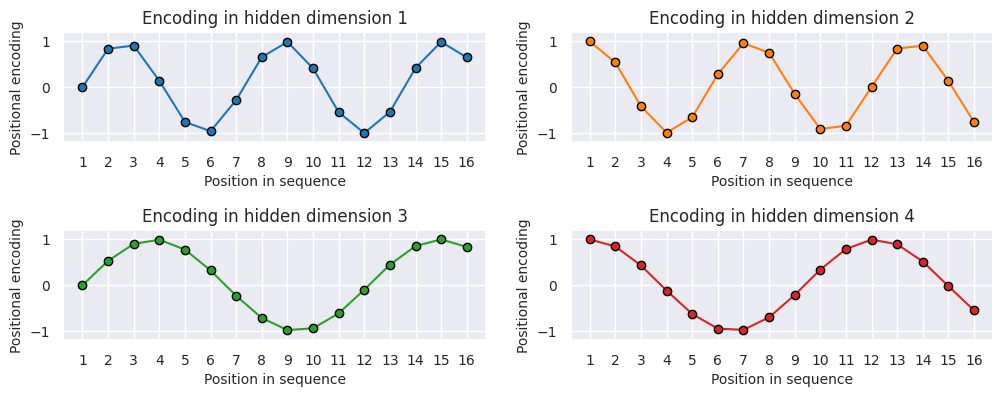

In [23]:
pe = jax.device_get(enc.pe.squeeze().T)

sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()


### PositionalEncoder with Learnable Parameters

In [24]:
class LearnablePositionalEncoder(nn.Module):
    d_model : int         	# Hidden dimensionality of the input.
    param_dim: int		 	# Number of learnable parameters.		
    max_len : int = 16  	# Maximum length of a sequence to expect.

    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len, dtype=np.float32)[:,None]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[None]
        self.pe = jax.device_put(pe)
        
		# Create learnable parameter embedding and initialize it with normal distribution
        self.param_embedding = self.param('param_embedding', nn.initializers.normal(stddev=0.02), (self.param_dim, 1, self.d_model))
        self.param_embedding = jnp.transpose(self.param_embedding, (1, 0, 2))  # Shape: (1, param_dim, d_model)
        
		# Concatenate the learnable parameter embedding and positional encoding
        self.all_pe = jnp.concatenate([self.param_embedding, self.pe], axis=1)

    def __call__(self, x):
        x = x + self.all_pe[:, :x.shape[1]]
        return x


In [25]:
learnable_enc = LearnablePositionalEncoder(d_model=32, param_dim=5, max_len=seq_len)
learnable_enc_params = learnable_enc.init(jax.random.PRNGKey(0), jnp.ones((1, seq_len, 32)))

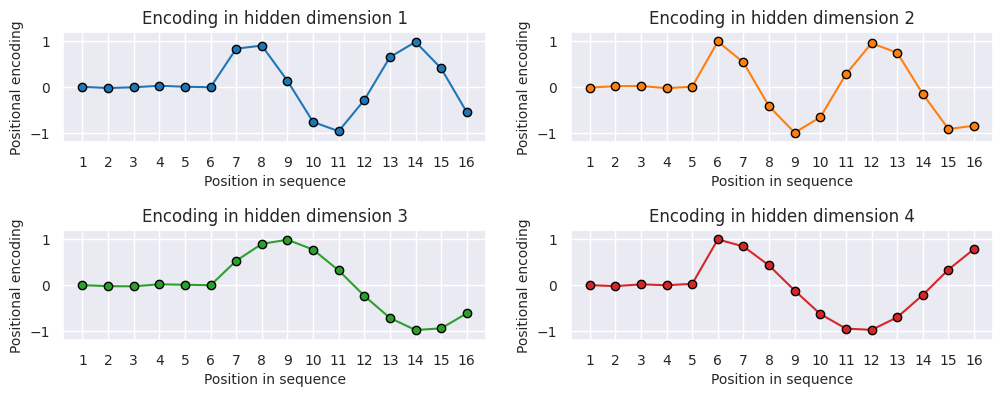

In [26]:
l_enc = learnable_enc.bind(learnable_enc_params)

l_pe = jax.device_get(l_enc.all_pe.squeeze().T)

sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), l_pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()


## Learning Rate WarmUp (Cosine Decay)

### Manual Warm Up

In [27]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    # Create function to return lr based on iteration count
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter <= warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr

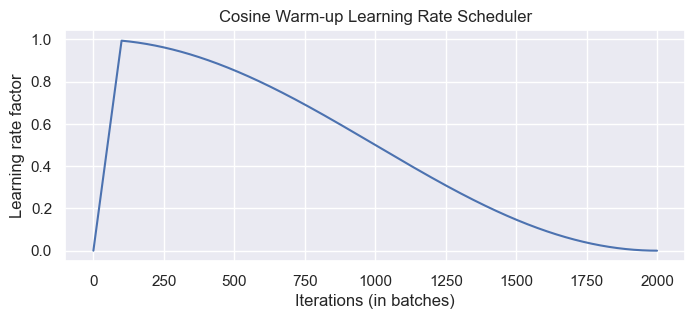

In [28]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

### Optax Implementation

In [29]:
from optax import warmup_cosine_decay_schedule

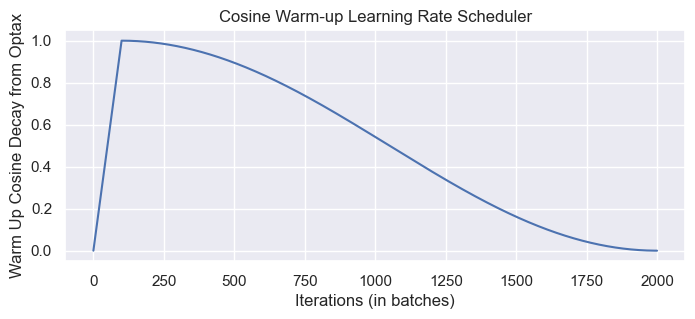

In [30]:
get_lr = warmup_cosine_decay_schedule(0., 1., 100, 2000)

epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [get_lr(e) for e in epochs])
plt.ylabel("Warm Up Cosine Decay from Optax")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

## Transformer

## Encoder Block

In [31]:
class EncoderBlock(nn.Module):
    input_dim: int
    num_heads: int
    feedfwd_dim: int
    dropout_rate: float
    
    def setup(self):
        # Multi-head attention layer
        self.attn_layer = nn.MultiHeadAttention(
            num_heads=self.num_heads,
            kernel_init=nn.initializers.xavier_uniform(),
            deterministic=False
		)
        
		# Feedforward layer
        self.linear_layers = [
			nn.Dense(features=self.feedfwd_dim),
            nn.Dropout(rate=self.dropout_rate),
            nn.relu,
			nn.Dense(features=self.input_dim)
		]
        
		# Layer normalization
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        
		# Dropout layer for residual connections
        self.dropout = nn.Dropout(rate=self.dropout_rate)
        
		
    def __call__(self, x, mask=None, train=True):
        # Multi-head attention
        attn = self.attn_layer(x, mask=mask, deterministic=not train)
        
		# First residual connection and layer normalization
        x = x + self.dropout(attn, deterministic=not train)
        x = self.norm1(x)
		
		# Feedforward layer
        linear_out = x
        for layer in self.linear_layers:
            linear_out = layer(linear_out) if not isinstance(layer, nn.Dropout) else layer(linear_out, deterministic=not train)
        
		# Second residual connection and layer normalization
        x = self.dropout(linear_out, deterministic=not train)
        x = self.norm2(x)
		
        return x
		

### Transformer

In [32]:
import math
import flax.linen as nn
import jax.numpy as jnp


def expand_mask(mask):
    assert jnp.ndim(mask) >= 2, "Mask should have at least two dimensions"
    
    if jnp.ndim(mask) == 3:
        mask = jnp.expand_dims(mask, axis=1)
    while jnp.ndim(mask) < 4:
        mask = jnp.expand_dims(mask, axis=0)
    return mask


def scaled_dot_product_attn(q, k, v, mask = None):
    d_k = q.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)

    if mask is not None:
        attn_logits = jnp.where(mask == 0, float('-inf'), attn_logits)

    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention, v)   
    return values, attention


class MultiheadAttention(nn.Module):
    embed_dim: int # Output dimension
    num_heads: int # number of parallel heads


    def setup(self):
        self.qkv_proj = nn.Dense(
            3 * self.embed_dim,
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros
        )

        self.out_proj = nn.Dense(
            self.embed_dim,
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros
        )

    def __call__(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.shape
        # mask = expand_mask(mask) if mask is not None else None

        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1)
        qkv = qkv.transpose((0, 2, 1, 3)) # [batch_size, num_heads, seq_length, embed_dim]
        q, k, v = jnp.array_split(qkv, 3, axis=-1)

        values, attention = scaled_dot_product_attn(q, k, v, mask)
        values = values.transpose((0, 2, 1, 3)) # [batch_size, seq_length, num_heads, embed_dim]
        values = values.reshape(batch_size, seq_length, embed_dim)
        output = self.out_proj(values)

        # clean up
        del qkv, q, k, v, values, batch_size, seq_length, embed_dim

        return output, attention
    

class EncoderBlock(nn.Module):
    input_dim: int
    num_heads: int
    dim_feedforward: int
    dropout_prob: float

    def setup(self):
        self.self_attn = MultiheadAttention(self.input_dim, self.num_heads)

        # MLP
        self.linear = [
            nn.Dense(self.dim_feedforward),
            nn.Dropout(rate=self.dropout_prob),
            nn.relu,
            nn.Dense(self.input_dim),
        ]

        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(rate=self.dropout_prob)

    def __call__(self, x, mask=None, train=True):

        # attention block
        attn_output, _ = self.self_attn(x, mask)
        x += self.dropout(attn_output, deterministic=not train)
        x = self.norm1(x)

        # feedforward block
        mlp_output = x
        for layer in self.linear:
            mlp_output = layer(mlp_output) if not isinstance(layer, nn.Dropout) else layer(mlp_output, deterministic=not train)

        x += self.dropout(mlp_output, deterministic=not train)
        x = self.norm2(x)

        return x
    

In [33]:
import dataclasses

In [52]:
class TransformerEncoder(nn.Module):
    seq_len: int
    num_layers: int
    input_dim: int
    num_heads: int
    dim_feedforward: int
    dropout_prob: float
    
	# embedding parameters
    _: dataclasses.KW_ONLY
    embed_dim: int = 32
    num_embeddings: int	= 2

    def setup(self):
        self.layers = [EncoderBlock(self.input_dim, self.num_heads, self.dim_feedforward, self.dropout_prob) for _ in range(self.num_layers)]
        self.embedding = nn.Embed(num_embeddings=self.num_embeddings, features=self.embed_dim)
        self.pos_encoder = PositionalEncoder(d_model=self.embed_dim, max_len=self.seq_len)
        
		# set the dimension of the amplitude head to the num_embeddings
        self.amplitude_head = nn.Dense(features=self.num_embeddings)

    def __call__(self, x, mask=None, train=True):
        # Setup mask
        mask = self._generate_mask(x.shape[1]) if mask is None else mask

        # Step: Positional encoding + input embedding
        x = jnp.squeeze(x, axis=-1)
        x = self.embedding(x)
        x = self.pos_encoder(x)
        
        # Step: Get logits from the transformer encoder
        for layer in self.layers:
            x = layer(x, mask=mask, train=train)
        
		# Step: Apply Log-softmax to get probabilities
        x = self.amplitude_head(x)
        x = nn.activation.log_softmax(x)
        
		# Step: Return the probabilities
        return x

    def get_attention_maps(self, x, mask=None, train=True):
        # A function to return the attention maps within the model for a single application used for visualization purpose later
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
        return attention_maps
    
    @staticmethod
    def _generate_mask(sz):
        mask = jnp.triu(jnp.ones((sz, sz)), k=1).T
        mask = jnp.where(mask == 0, -jnp.inf, 0.0)
        # mask = jnp.triu(jnp.ones((sz, sz)), k=1)
        return jnp.tril(jnp.ones((sz, sz)))

In [53]:
model = TransformerEncoder(seq_len=16, num_layers=8, input_dim=32, num_heads=8, dim_feedforward=64, dropout_prob=0.0)
print(model)

TransformerEncoder(
    # attributes
    seq_len = 16
    num_layers = 8
    input_dim = 32
    num_heads = 8
    dim_feedforward = 64
    dropout_prob = 0.0
    embed_dim = 32
    num_embeddings = 2
)


In [55]:
dummy_input = jnp.zeros((1, 16, 1), dtype=jnp.int32)
params = model.init(jax.random.PRNGKey(0), dummy_input)['params']

# jax.tree_util.tree_map(lambda x: x.shape, params)

In [62]:
real_input = jnp.zeros((0,1, 1), dtype=jnp.int32)
output = model.apply({'params': params}, real_input, train=True)

ZeroDivisionError: integer modulo by zero

In [61]:
sample = random.categorical(random.PRNGKey(23), output)
sample.shape

(1, 16)

In [39]:
samples = jnp.zeros((500,16, 1), dtype=jnp.int32)
log_prob = model.apply({'params': params}, samples, train=True)
random.categorical(random.PRNGKey(23), log_prob)

Array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

## NNX Transformer

In [42]:
import math
import numpy as np
from flax import nnx
from jax import random
from typing import Dict
from dataclasses import KW_ONLY, field
from flax.linen import MultiHeadAttention, make_causal_mask, Embed
from flax.linen.initializers import xavier_uniform, zeros

In [201]:
attention_kwargs = dict(
    num_heads=8,
    qkv_features=16,
    kernel_init=xavier_uniform,
    bias_init=zeros,
    dropout_rate=0.5,
    deterministic=False,
)

class NQS(nn.Module):
    seq_len: int
    num_layers: int
    dropout_prob: float
    
    _: KW_ONLY
	# embedding parameters
    embed_dim: int = 32
    num_embeddings: int	= 2
    

    def setup(self):
        self.layers = [
            MultiHeadAttention(
                num_heads=8,
				kernel_init=xavier_uniform(),
                dropout_rate=self.dropout_prob,
			) 
            	for _ in range(self.num_layers)
        ]
        self.embedding = Embed(num_embeddings=self.num_embeddings, features=self.embed_dim)
        self.pos_encoder = PositionalEncoder(d_model=self.embed_dim, max_len=self.seq_len)
        
		# set the dimension of the amplitude head to the num_embeddings
        self.amplitude_head = nn.Dense(features=self.num_embeddings)

    def __call__(self, x, mask=None, train=True):
        # Setup mask
        mask = make_causal_mask(x) if mask is None else mask

        # Step: Positional encoding + input embedding
        # x = jnp.squeeze(x, axis=-1)
        x = self.embedding(x)
        x = self.pos_encoder(x)
        
        # Step: Get logits from the transformer encoder
        for layer in self.layers:
            x = layer(x, mask=mask, deterministic=not train)
        
		# Step: Apply Log-softmax to get probabilities
        x = self.amplitude_head(x)
        x = nn.activation.log_softmax(x, axis=-1)
        
		# Step: Return the probabilities
        return x

    def get_attention_maps(self, x, mask=None, train=True):
        # A function to return the attention maps within the model for a single application used for visualization purpose later
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
        return attention_maps
    
    @staticmethod
    def _generate_mask(sz):
        mask = jnp.triu(jnp.ones((sz, sz)), k=1).T
        mask = jnp.where(mask == 0, -jnp.inf, 0.0)
        # mask = jnp.triu(jnp.ones((sz, sz)), k=1)
        return mask

In [46]:
layer = nn.MultiHeadAttention(num_heads=8, qkv_features=16)
key1, key2, key3, key4, key5, key6 = jax.random.split(jax.random.key(0), 6)
shape = (4, 3, 2, 5)
q, k, v = jax.random.uniform(key1, shape), jax.random.uniform(key2, shape), jax.random.uniform(key3, shape)
variables = layer.init(jax.random.key(0), q)

In [202]:
input_shape = (1,16)
nqs = NQS(seq_len=16, num_layers=8, dropout_prob=0.0)
params = nqs.init(jax.random.PRNGKey(0), jnp.ones(input_shape, dtype=jnp.int32))['params']

In [149]:
n = 16
keys = jax.random.split(jax.random.PRNGKey(0), n)
dropout_keys = jax.random.split(jax.random.PRNGKey(1), n)

samples = None
samples = jnp.zeros((500,1), dtype=jnp.int32)
for i in range(n-1):
	log_prob = nqs.apply({'params': params}, samples, train=True, rngs={'dropout': dropout_keys[i]})

	# take the last log-probability
	log_prob = log_prob[:, -1, :]
	sample = random.categorical(keys[i], log_prob)
	sample = jnp.expand_dims(sample, axis=1)

	samples = sample if samples is None else jnp.concatenate([samples, sample], axis=1)

In [174]:
def sample_from_transformer(nqs, params, num_samples, sequence_length, sample_key, dropout_key):
	
	samples = jnp.zeros((num_samples, 1), dtype=jnp.int32)
	sample_keys = jax.random.split(sample_key, sequence_length)
	dropout_keys = jax.random.split(dropout_key, sequence_length)

	for i in range(sequence_length):
		log_prob = nqs.apply({'params': params}, samples, train=True, rngs={'dropout': dropout_keys[i]})

		# take the last log-probability
		log_prob = log_prob[:, -1, :]

		# sample from the log-probabilities
		sample = random.categorical(sample_keys[i], log_prob)
		sample = jnp.expand_dims(sample, axis=1)

		samples = sample if i == 0 else jnp.concatenate([samples, sample], axis=1)
	return samples

def transfomer_logpsi(params, x, nqs, dropout_key, train=True):
	log_probs = nqs.apply({'params': params}, x, train=train, rngs={'dropout': dropout_key})
	logP = jnp.sum(jnp.multiply(log_probs, jax.nn.one_hot(samples, 2)), axis=2)
	logpsi = 0.5 * jnp.sum(logP, axis=1)
	return logpsi

In [164]:
samples = sample_from_transformer(nqs, params, 500, 16, random.PRNGKey(0), random.PRNGKey(1))

In [175]:
logpsi = transfomer_logpsi(params, samples, nqs, random.PRNGKey(0), train=True)

In [177]:
logpsi.shape

(500,)

In [181]:
from typing import List, Tuple, Union
from abc import ABC, abstractmethod
from dataclasses import dataclass
import jax.numpy as jnp
from jax import nn as jnn
from jax import random, jit, lax, value_and_grad
from flax import linen as nn
from functools import partial, lru_cache
import jax.tree_util as tree_util   
import optax

In [182]:
@lru_cache(maxsize=128, typed=False)
def get_all_interactions_jax(n: int) -> tuple:
    """
    Get all to all interactions from a n by n lattice using the euclidean distances.
    Assume a unit distance (1) between nearest neighbours

    Parameters
    ---
    n: integer representing a side of the square

    Output
    ---
    tuple[unique_pairs, multipliers]
    """

    # Create a grid of coordinates
    x, y = jnp.meshgrid(jnp.arange(n), jnp.arange(n))
    coordinates = jnp.stack([x.flatten(), y.flatten()], axis=1)

    # Calculate distances between all unique pairs
    num_points = coordinates.shape[0]
    distances = jnp.sqrt(
        jnp.sum((coordinates[:, None, :] - coordinates[None, :, :]) ** 2, axis=-1)
    )

    # Mask to select only unique pairs
    mask = jnp.triu(jnp.ones((num_points, num_points), dtype=bool), k=1)

    # Extract unique pairs, distances, and calculate multipliers
    unique_pairs = jnp.argwhere(mask)
    unique_distances = distances[mask]
    multipliers = 1 / unique_distances ** 6

    return unique_pairs, multipliers

In [235]:
@dataclass
class VMC:
    nsamples: int
    n: int
    learning_rate: float
    num_epochs: int
    output_dim: int
    sequence_length: int
    num_hidden_units: int

    def __post_init__(self):
        self.pairs, self.multipliers = get_all_interactions_jax(self.n)
        self.Omega = 1.0
        self.delta = 1.0

    
    
    def sample(self, key, params, model) -> List[Union[float, Tuple[float, ...]]]:
        sample_key, dropout_key = random.split(key)
        samples = jnp.zeros((self.nsamples, 1), dtype=jnp.int32)
        sample_keys = jax.random.split(sample_key, self.sequence_length)
        dropout_keys = jax.random.split(dropout_key, self.sequence_length)

        for i in range(self.sequence_length):
            log_prob = model.apply({'params': params}, samples, train=True, rngs={'dropout': dropout_keys[i]})

			# take the last log-probability
            log_prob = log_prob[:, -1, :]

			# sample from the log-probabilities
            sample = random.categorical(sample_keys[i], log_prob)
            sample = jnp.expand_dims(sample, axis=1)

            samples = sample if i == 0 else jnp.concatenate([samples, sample], axis=1)

        return samples
    
    # def sample(self, key, params, model) -> List[Union[float, Tuple[float, ...]]]:
    #     sample_key, dropout_key = random.split(key)
    #     samples = jnp.zeros((self.nsamples, 1), dtype=jnp.int32)
    #     sample_keys = jax.random.split(sample_key, self.sequence_length)
    #     dropout_keys = jax.random.split(dropout_key, self.sequence_length)
        
        
    #     def step(i, state):
    #         # network_input = lax.dynamic_slice(operand=state, start_indices=(0, 0), slice_sizes=(self.nsamples, i+1))
    #         network_input, samples = state
    #         log_prob = model.apply({'params': params}, network_input, train=True, rngs={'dropout': dropout_keys[i]})
    #         log_prob = log_prob[:, -1, :]
    #         sample = random.categorical(sample_keys[i], log_prob)
    #         sample = jnp.expand_dims(sample, axis=1)
    #         samples = lax.dynamic_update_slice(operand=samples, update=sample, start_indices=(0, i))
    #         network_input = jnp.concatenate([network_input, sample], axis=1)
    #         return network_input, state
        
    #     initial_samples = jnp.zeros((self.nsamples, self.sequence_length), dtype=jnp.int32)
    #     initial_input = jnp.zeros((self.nsamples, 1), dtype=jnp.int32)
    #     samples = lax.fori_loop(0, self.sequence_length, step, (initial_input, initial_samples))
        
    #     return samples
    

    def logpsi(self, samples: List[Union[float, Tuple[float, ...]]], params, model, dropout_key) -> List[float]:
        ss = (0, self.sequence_length - 1)
        nsamples = samples.shape[0]
        data   = samples[:, ss[0]:ss[1]]
        inputs = jnp.concatenate([jnp.zeros((nsamples, 1), dtype=jnp.int32), data], axis = 1)

        log_probs = model.apply({'params': params}, inputs, train=False, rngs={'dropout': dropout_key})

        logP   = jnp.sum(jnp.multiply(log_probs, jnn.one_hot(samples, self.output_dim)), axis=2)
        logP = 0.5 * jnp.sum(logP, axis=1)
        return logP
    
    


    def get_loss(self, params, rng_key, model):
        def l2_loss(x, alpha):
            return alpha * (x ** 2).mean()

        @jit
        def all_reg():
            return sum(
                l2_loss(w, alpha=0.001) for w in tree_util.tree_leaves(params["params"])
            )
        
        s_key, d_key = random.split(rng_key, 2)

        samples = self.sample(s_key, params, model)
        log_psi = self.logpsi(samples, params, model)
        e_loc = self.local_energy(samples, params, model, log_psi, d_key)
        e_o = e_loc.mean()

        # We expand the equation in the text above
        first_term = 2 * jnp.multiply(log_psi, e_loc)
        second_term = 2 * jnp.multiply(e_o, log_psi)

        # l2_reg = all_reg()

        loss = jnp.mean(first_term - second_term)
        # loss = l2_reg(params) + loss
        # loss += l2_reg
        return loss, e_loc
    

    def train(self, rng_key, params, model):
        rng_key = random.PRNGKey(0)
        
        optimizer = optax.adam(learning_rate=self.learning_rate)
        opt_state = optimizer.init(params)

        loss_fn = self.get_loss
    

        @partial(jit, static_argnums=(3,))
        def step(params, rng_key, opt_state, get_loss=loss_fn):
            rng_key, new_key = random.split(rng_key)

            value, grads = value_and_grad(get_loss, has_aux=True)(params, rng_key, model)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return new_key, params, opt_state, value

        energies = []
        for i in range(self.num_epochs):
            rng_key, params, opt_state, (loss, eloc) = step(params, rng_key, opt_state)
            energies.append(eloc)

            if i % 100 == 0:
                print(f'step {i}, loss: {loss}')

        return energies
    
    
    
    def local_energy(self, samples, params, model, log_psi, dropout_key) -> List[float]:
        output = jnp.zeros((samples.shape[0]), dtype=jnp.float32)

        def step_fn_chemical(i, state):
            s, output = state
            output += - self.delta * s[:, i]
            return s, output

        def step_fn_intr(i, state):
            samples, pairs, multipliers, output = state
            output += multipliers[i] * samples[:, pairs[i, 0]] * samples[:, pairs[i, 1]]
            return samples, pairs, multipliers, output


        def step_fn_transverse(i, state):
            s, output = state
            flipped_state = s.at[:, i].set(1 - s[:, i])
            flipped_logpsi = self.logpsi(flipped_state, params, model, dropout_key)
            output += - self.Omega * jnp.exp(flipped_logpsi - log_psi)
            return s, output


    	# Interaction Term
        _, _, _, interaction_term = lax.fori_loop(0, 120, step_fn_intr, (samples, self.pairs, self.multipliers, output))
        # Off Diagonal Term
        _, transverse_field = lax.fori_loop(0, 16, step_fn_transverse, (samples, output))
        # _, transverse_field = lax.fori_loop(0, 16, step_fn_transverse, (samples, output))
        # Occupancy Term
        _, chemical_potential = lax.fori_loop(0, 16, step_fn_chemical, (samples, output))

        # Total energy
        loc_e = transverse_field + chemical_potential + interaction_term
		
        return loc_e

In [184]:
from typing import NamedTuple

class VMCConfig(NamedTuple):
    nsamples: int = 500
    n: int = 4
    learning_rate: float = 0.005
    num_epochs: int = 1000
    output_dim: int = 2
    sequence_length: int = 16
    num_hidden_units: int = 64

In [185]:
config = VMCConfig()
config

VMCConfig(nsamples=1000, n=4, learning_rate=0.005, num_epochs=1000, output_dim=2, sequence_length=16, num_hidden_units=64)

In [236]:
vmc = VMC(**config._asdict())

In [237]:
rng_key = random.PRNGKey(0)
densities = vmc.train(rng_key, params, nqs)

TypeError: Scanned function carry input and carry output must have the same pytree structure, but they differ:
  * the input carry component loop_carry[1][1] is a <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> but the corresponding component of the carry output is a <class 'tuple'>, so their Python types differ

Revise the scanned function so that its output is a pair where the first element has the same pytree structure as the first argument.